### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle

import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy as sc
import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

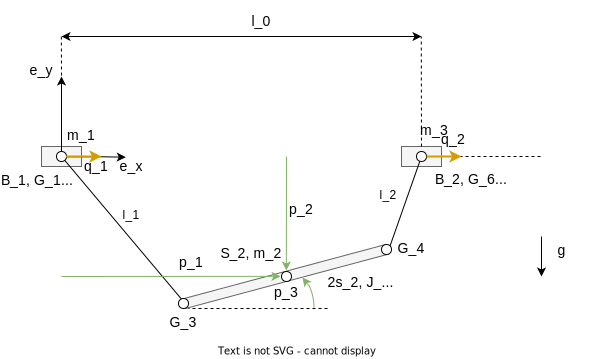

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_simulation_diagram.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates (not directly actuated)
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(4+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

# define symbols for measured states
p_meas = st.symb_vector("pm1:{0}".format(3+1)) # error vector of passive coordinates
q_meas = st.symb_vector("qm1:{0}".format(2+1)) # error vector of actuated coordinates

meas_states = st.row_stack(p_meas, q_meas) ##:T
meas_states_d = st.time_deriv(meas_states, meas_states) ##:T

st.make_global(meas_states, meas_states_d)

# define symbols for reference trajectory states
p_ref = st.symb_vector("pr1:{0}".format(3+1)) # error vector of passive coordinates
q_ref = st.symb_vector("qr1:{0}".format(2+1)) # error vector of actuated coordinates

ref_states = st.row_stack(p_ref, q_ref)
ref_states_d = st.time_deriv(ref_states, ref_states)
ref_states_dd = st.time_deriv(ref_states, ref_states, order=2)
ref_states_ddd = st.time_deriv(ref_states, ref_states, order=3)
ref_states_dddd = st.time_deriv(ref_states, ref_states, order=4)

st.make_global(ref_states, ref_states_d, ref_states_dd, ref_states_ddd, ref_states_dddd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

aa.T := [a₁  a₂  a₃  a₄]

---

ttheta.T := [p₁  p₂  p₃  q₁  q₂]

---

tthetad.T := [ṗ₁  ṗ₂  ṗ₃  q̇₁  q̇₂]

---

tthetadd.T := [p̈₁  p̈₂  p̈₃  q̈₁  q̈₂]

---

tthetaddd.T := [p⃛₁  p⃛₂  p⃛₃  q⃛₁  q⃛₂]

---

tthetadddd.T := [p⃜₁  p⃜₂  p⃜₃  q⃜₁  q⃜₂]

---

meas_states.T := [pm₁  pm₂  pm₃  qm₁  qm₂]

---

meas_states_d.T := [pṁ₁  pṁ₂  pṁ₃  qṁ₁  qṁ₂]

---

QQ.T := [Q₁  Q₂  Q₃  Q₄  Q₅]

---

In [4]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")

Specify the geometry (joints G and centers of masses S)

In [5]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G6 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])

# suspension points of load
G3 = S2 - Rz(p3)*ex*s2 ##:
G4 = S2 + Rz(p3)*ex*s2 ##:

# Time derivatives of centers of masses
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta)) ##:

# rope vectors
rope1 = (G3 - S1)
rope2 = (G4 - S3)

B1 := ⎡q₁⎤
⎢  ⎥
⎣0 ⎦

---

B2 := ⎡l₀ + q₂⎤
⎢       ⎥
⎣   0   ⎦

---

G3 := ⎡p₁ - s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ - s₂⋅sin(p₃)⎦

---

G4 := ⎡p₁ + s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ + s₂⋅sin(p₃)⎦

---

(Sd1, Sd2, Sd3) := ⎛⎡q̇₁⎤  ⎡ṗ₁⎤  ⎡q̇₂⎤⎞
⎜⎢  ⎥, ⎢  ⎥, ⎢  ⎥⎟
⎝⎣0 ⎦  ⎣ṗ₂⎦  ⎣0 ⎦⎠

---

# Initial values

In [6]:
# load model etc. from pickle of flatness analysis notebook
with open("flatness_analysis_control.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

In [7]:
# load model etc. from pickle of flatness analysis notebook
with open("qstat_expr.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

In [8]:
qstat_tau2.co

In [9]:
sys_params = list(dict(J2=0.004553475, g=9.81, l0=0.3, m1=0.45, m2=0.557, m3=0.45, s2=0.15).items()) ##:

sys_params := [('J2', 0.004553475),
 ('g', 9.81),
 ('l0', 0.3),
 ('m1', 0.45),
 ('m2', 0.557),
 ('m3', 0.45),
 ('s2', 0.15)]

---

In [10]:
eqns.subz0(tthetadd)

⎡                                               τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃)
⎢                                             - ──────────────────────────────
⎢                                                              l₂             
⎢                                                                             
⎢                                                         τ₄⋅(p₂ + s₂⋅sin(p₃))
⎢                                                  g⋅m₂ - ────────────────────
⎢                                                                  l₂         
⎢                                                                             
⎢  s₂⋅τ₄⋅(p₂ + s₂⋅sin(p₃))⋅cos(p₃)   s₂⋅τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))⋅sin(p₃
⎢- ─────────────────────────────── + ─────────────────────────────────────────
⎢                 l₂                                     l₂                   
⎢                                                                             
⎢                                                   

In [11]:
# determine a symetrical equilibrium:
# TODO: woher Wahl von ttau?
eqlbr_conditions = [(q1, 0), (p1, 0.15), (p2, -0.4), (p3, 0), (tau1, 0), (tau2, 0), (tau3, tau4)] ##:

res = ((mod.eqns.subz0(tthetadd)).subs(eqlbr_conditions)).subs(sys_params) ##:

---

res := ⎡              q₂⋅τ₄               ⎤
⎢         ───────────────          ⎥
⎢            ____________          ⎥
⎢           ╱   2                  ⎥
⎢         ╲╱  q₂  + 0.16           ⎥
⎢                                  ⎥
⎢              0.4⋅τ₄              ⎥
⎢1.0⋅τ₄ + ─────────────── + 5.46417⎥
⎢            ____________          ⎥
⎢           ╱   2                  ⎥
⎢         ╲╱  q₂  + 0.16           ⎥
⎢                                  ⎥
⎢                   0.06⋅τ₄        ⎥
⎢    -0.15⋅τ₄ + ───────────────    ⎥
⎢                  ____________    ⎥
⎢                 ╱   2            ⎥
⎢               ╲╱  q₂  + 0.16     ⎥
⎢                                  ⎥
⎢                0                 ⎥
⎢                                  ⎥
⎢             -q₂⋅τ₄               ⎥
⎢         ───────────────          ⎥
⎢            ____________          ⎥
⎢           ╱   2                  ⎥
⎣         ╲╱  q₂  + 0.16           ⎦

---

In [12]:
symbs = list(res.s) ##:
sol = sp.solve(res, symbs, dict=True) ##:

---

---

In [13]:
ttheta0 = st.to_np(ttheta.subs(eqlbr_conditions).subs(sol[0])).squeeze() ##:

uu0 = st.to_np(ttau.subs(eqlbr_conditions).subs(sol[0])).squeeze()##:

ttheta0 := array([ 0.15, -0.4 ,  0.  ,  0.  ,  0.  ])

---

uu0 := array([ 0.      ,  0.      , -2.732085, -2.732085])

---

# Trajectory planning
The parametrization of $\tau_2$ determines the highest required order $N_i$ of the flat output's derivatives. For each component of the flat output a trajectory $y_i$ can be chosen with a polynomial order of $\alpha_i = 2 N_i + 1$ in compliance with the system's initial values.

In [14]:
T0, T1 = 0, 10
p10, p20, p30, q10 = ttheta0[:-1] ##:
p1e, p2e, p3e, q1e = ttheta0[:-1] - 0.3 ##:
# p10 = p10 + 0.2
# p20 = p20 + 0.15
# q10 = q10 + 0.15
# p30 = p30 + 0.1
# polynoms of order 9 (boundary conditions until 4th derivative due to usage of qddot2 later) for p_i
p1_traj = st.condition_poly(t, (T0, p10, 0, 0, 0, 0), (T1, p1e, 0, 0, 0, 0)) ##:
p2_traj = st.condition_poly(t, (T0, p20, 0, 0, 0, 0), (T1, p2e, 0, 0, 0, 0)) ##:
p3_traj = st.condition_poly(t, (T0, p30, 0, 0, 0, 0), (T1, p3e, 0, 0, 0, 0)) ##:
# polynoms of order 5 (boundary conditions until 2nd derivative) for q_1
q1_traj = st.condition_poly(t, (T0, q10, 0, 0), (T1, q1e, 0, 0)) ##:
# trajectory for q2 from flatness relations 
q2_traj = flat_q2.subz([p1, p2, p3, pddot1, pddot2, pddot3, q1], [p1_traj, p2_traj, p3_traj, p1_traj.diff(t, 2), p2_traj.diff(t, 2), p3_traj.diff(t, 2), q1_traj])
q2_traj = q2_traj.subs(sys_params)

---

---

---

---

---

---

Substitution of $\mathbf{y}$ with trajectories into control inputs

In [15]:
flat_quantities = [p1, p2, p3, q1, q2,
                   pdot1, pdot2, pdot3, qdot1, qdot2,
                   pddot1, pddot2, pddot3, qddot1, qddot2,
                   pdddot1, pdddot2, pdddot3, 
                   pddddot1, pddddot2, pddddot3]

flat_quant_subs = [p1_traj, p2_traj, p3_traj, q1_traj, q2_traj,
                   p1_traj.diff(t), p2_traj.diff(t), p3_traj.diff(t), q1_traj.diff(t), q2_traj.diff(t),
                   p1_traj.diff(t, 2), p2_traj.diff(t, 2), p3_traj.diff(t, 2), q1_traj.diff(t, 2), q2_traj.diff(t, 2),
                   p1_traj.diff(t, 3), p2_traj.diff(t, 3), p3_traj.diff(t, 3),
                   p1_traj.diff(t, 4), p2_traj.diff(t, 4), p3_traj.diff(t, 4)]

In [16]:
%%time

tau1_traj = flat_tau1.subz(flat_quantities, flat_quant_subs)
tau2_traj = flat_tau2.subz(flat_quantities, flat_quant_subs)
tau3_traj = flat_tau3.subz(flat_quantities, flat_quant_subs)
tau4_traj = flat_tau4.subz(flat_quantities, flat_quant_subs)

# verify that only constant system parameters, the time and measured quantities are included
set([*tau1_traj.s, *tau2_traj.s, *tau3_traj.s, *tau4_traj.s]) ##:

---

CPU times: user 1min 39s, sys: 19.1 ms, total: 1min 39s
Wall time: 1min 39s


In [17]:
tau1_traj_num = tau1_traj.subs(sys_params)
tau2_traj_num = tau2_traj.subs(sys_params)
tau3_traj_num = tau3_traj.subs(sys_params)
tau4_traj_num = tau4_traj.subs(sys_params)

In [18]:
tau1_traj_num.s

In [19]:
tau1_traj_num.s

In [20]:
tau1_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau1_traj_num)
tau2_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau2_traj_num)
tau3_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau3_traj_num)
tau4_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau4_traj_num)

In [21]:
# dito for reference trajectories for later plotting
p1_traj_func = st.expr_to_func(t, p1_traj)
p2_traj_func = st.expr_to_func(t, p2_traj)
p3_traj_func = st.expr_to_func(t, p3_traj)
q1_traj_func = st.expr_to_func(t, q1_traj)
q2_traj_func = st.expr_to_func(t, q2_traj)

# Simulation model

In [22]:
mod.xx

⎡p₁⎤
⎢  ⎥
⎢p₂⎥
⎢  ⎥
⎢p₃⎥
⎢  ⎥
⎢q₁⎥
⎢  ⎥
⎢q₂⎥
⎢  ⎥
⎢ṗ₁⎥
⎢  ⎥
⎢ṗ₂⎥
⎢  ⎥
⎢ṗ₃⎥
⎢  ⎥
⎢q̇₁⎥
⎢  ⎥
⎣q̇₂⎦

In [23]:
sim = st.SimulationModel(mod.f, mod.g, mod.xx, model_parameters=sys_params)

In [24]:
# control forces for stabilizing equilbrium
uu1 = uu0
def composite_force(x, t):
    # friction constants
    di = 10
    dissipation1 = -di*x[8]
    dissipation2 = -di*x[9]
    control_force = 0
    
    forces = uu1 #+ [dissipation1, dissipation2, 0.0, 0.0]
    return forces

# control forces for driving feed forward trajectories
def feed_forward_traj(x, t):
    if t < 1e-2:
        forces = uu1        
    elif t < 9.99:
        
        u1 = tau1_traj_func(t, *x)
        u2 = tau2_traj_func(t, *x)
        u3 = tau3_traj_func(t, *x)
        u4 = tau4_traj_func(t, *x)
        
        forces = [u1, u2, u3, u4]
    else:
        u1 = tau1_traj_func(9.99, *x)
        u2 = tau2_traj_func(9.99, *x)
        u3 = tau3_traj_func(9.99, *x)
        u4 = tau4_traj_func(9.99, *x)
        forces = [u1, u2, u3, u4]
    return forces

In [25]:
rhs = sim.create_simfunction(controller_function=feed_forward_traj)

In [26]:
xx0 = npy.concatenate((ttheta0, ttheta0*0)) ##:
#xx0 += npy.array([0.05, 0, 0, 0, 0,     0, 0, 0, 0, 0])
#xx0 += npy.array([0.1, -0.15, 0.15, 0.1, 0.05,     0, 0, 0, 0, 0])

xx0 := array([ 0.15, -0.4 ,  0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.  ])

---

In [27]:
tt = npy.linspace(0, 20, 2000)

In [28]:
rhs(xx0, 0)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.24344979e-14,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [29]:
%%time
# solve_ivp is more modern, but the signature of rhs is taylored towards odeint
res = sc_integrate.odeint(rhs, xx0, tt) ##:i

info(res) := "<class 'numpy.ndarray'> with shape: (2000, 10)"

---

CPU times: user 9.35 s, sys: 0 ns, total: 9.35 s
Wall time: 9.35 s


In [30]:
res[0, :]

array([ 0.15, -0.4 ,  0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.  ])

In [31]:
# numeric trajs
p1_num = st.expr_to_func(t, p1_traj)
p2_num = st.expr_to_func(t, p2_traj)
p3_num = st.expr_to_func(t, p3_traj)
q1_num = st.expr_to_func(t, q1_traj)
q2_num = st.expr_to_func(t, q2_traj)
pdot1_num = st.expr_to_func(t, p1_traj.diff(t))
pdot2_num = st.expr_to_func(t, p2_traj.diff(t))
pdot3_num = st.expr_to_func(t, p3_traj.diff(t))
qdot1_num = st.expr_to_func(t, q1_traj.diff(t))
qdot2_num = st.expr_to_func(t, q2_traj.diff(t))
# deviation of simulated and reference trajs
err_trajp1 = res[:1000, 0] - p1_num(tt[tt<10])
err_trajp2 = res[:1000, 1] - p2_num(tt[tt<10]) 
err_trajp3 = res[:1000, 2] - p3_num(tt[tt<10]) 
err_trajq1 = res[:1000, 3] - q1_num(tt[tt<10]) 
err_trajq2 = res[:1000, 4] - q2_num(tt[tt<10])
err_trajpdot1 = res[:1000, 5] - pdot1_num(tt[tt<10])
err_trajpdot2 = res[:1000, 6] - pdot2_num(tt[tt<10]) 
err_trajpdot3 = res[:1000, 7] - pdot3_num(tt[tt<10]) 
err_trajqdot1 = res[:1000, 8] - qdot1_num(tt[tt<10])
err_trajqdot2 = res[:1000, 9] - qdot2_num(tt[tt<10]) 
# ... mean
mean_err_trajp1 = npy.mean(abs(err_trajp1)) ##:
mean_err_trajp2 = npy.mean(abs(err_trajp2)) ##:
mean_err_trajp3 = npy.mean(abs(err_trajp3)) ##:
mean_err_trajq1 = npy.mean(abs(err_trajq1)) ##:
mean_err_trajq2 = npy.mean(abs(err_trajq2)) ##:

---

---

---

---

---

In [32]:
# stationary difference:
inf_err_trajp1 = abs(res[1500, 0] - p1_num(10)) ##:
inf_err_trajp2 = abs(res[1500, 1] - p2_num(10)) ##:
inf_err_trajp3 = abs(res[1500, 2] - p3_num(10)) ##:
inf_err_trajq1 = abs(res[1500, 3] - q1_num(10)) ##:

---

---

---

---

In [33]:
ttau = list(map(feed_forward_traj, res[1:1500, :] ,tt[1:1500]))
ttau1, ttau2, ttau3, ttau4 = zip(*ttau)

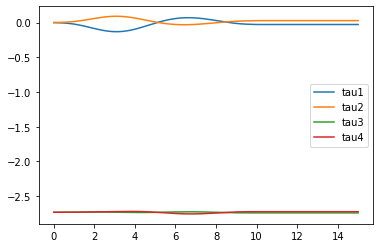

In [34]:
plt.plot(tt[1:1500], ttau1, label="tau1")
plt.plot(tt[1:1500], ttau2, label="tau2")
plt.plot(tt[1:1500], ttau3, label="tau3")
plt.plot(tt[1:1500], ttau4, label="tau4")
plt.legend()

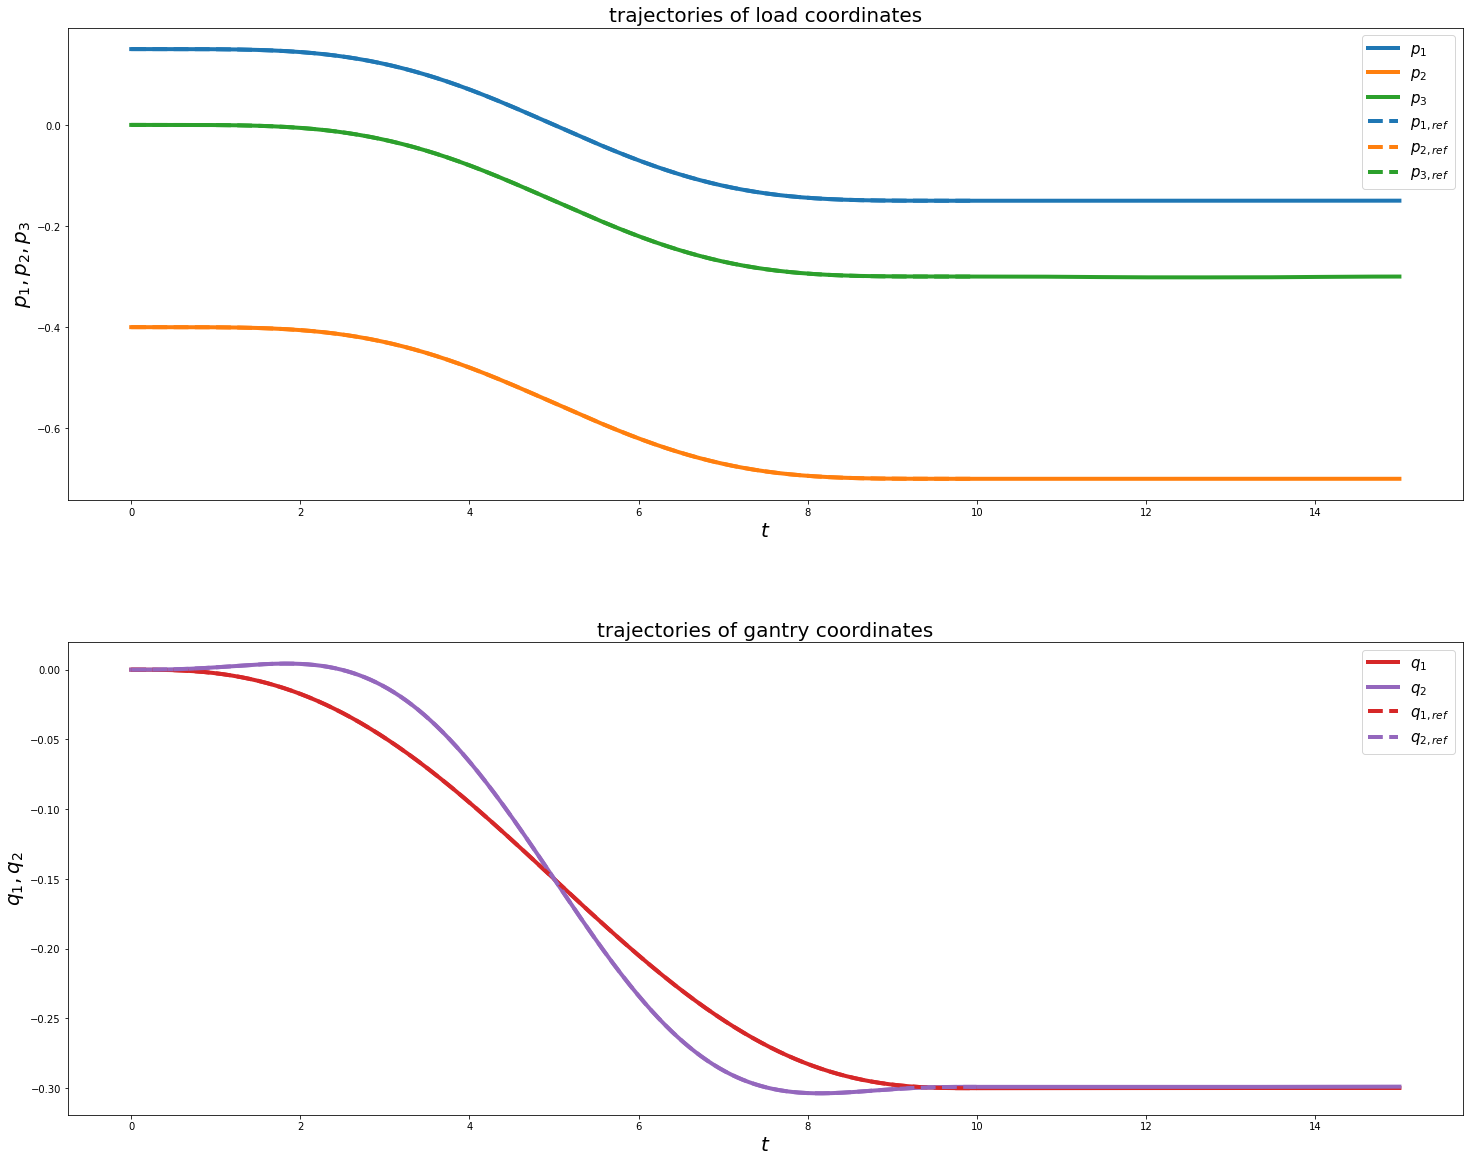

In [35]:
plt.rcParams['figure.figsize'] = [25, 20]
fig, axs = plt.subplots(2, 1)
plt.subplots_adjust(hspace = 0.3)

axs[0].plot(tt[:1500], res[:1500, 0], '#1f77b4', label=r'$p_{1}$', linewidth=4.0)
axs[0].plot(tt[:1500], res[:1500, 1], '#ff7f0e', label=r'$p_{2}$', linewidth=4.0)
axs[0].plot(tt[:1500], res[:1500, 2], '#2ca02c', label=r'$p_{3}$', linewidth=4.0)
axs[0].plot(tt[:1000], p1_traj_func(tt[:1000]), '#1f77b4', linestyle='--', label=r'$p_{1,ref}$', linewidth=4.0)
axs[0].plot(tt[:1000], p2_traj_func(tt[:1000]), '#ff7f0e', linestyle='--', label=r'$p_{2,ref}$', linewidth=4.0)
axs[0].plot(tt[:1000], p3_traj_func(tt[:1000]), '#2ca02c', linestyle='--', label=r'$p_{3,ref}$', linewidth=4.0)

axs[0].legend(prop={'size': 15})
axs[0].set_title('trajectories of load coordinates', fontsize=20)
axs[0].set_xlabel('$t$', fontsize=20)
axs[0].set_ylabel('$p_1, p_2, p_3$', fontsize=20)

axs[1].plot(tt[:1500], res[:1500, 3], '#d62728', label=r'$q_{1}$', linewidth=4.0)
axs[1].plot(tt[:1500], res[:1500, 4], '#9467bd', label=r'$q_{2}$', linewidth=4.0)
axs[1].plot(tt[:1000], q1_traj_func(tt[:1000]), '#d62728', linestyle='--', label=r'$q_{1,ref}$', linewidth=4.0)
axs[1].plot(tt[:1000], q2_traj_func(tt[:1000]), '#9467bd', linestyle='--', label=r'$q_{2,ref}$', linewidth=4.0)

axs[1].legend(prop={'size': 15})
axs[1].set_title('trajectories of gantry coordinates', fontsize=20)
axs[1].set_xlabel('$t$', fontsize=20)
axs[1].set_ylabel('$q_1, q_2$', fontsize=20)

plt.show()

### Stability analysis of current trajectories

In [36]:
xref, error, errord = sp.symbols('x_{ref} e_x \dot{e}_x')

In [37]:
eetheta = st.symb_vector("e1:{0}".format(len(ttheta)+1)) ##:T
eethetad = st.time_deriv(eetheta, eetheta, order=1) ##:T 
eethetadd = st.time_deriv(eetheta, eetheta, order=2) ##:T 

xxref = st.row_stack(ref_states, ref_states_d) ##:T
xxrefd = st.row_stack(ref_states_d, ref_states_dd) ##:T
eerror = st.row_stack(eetheta, eethetad) ##:T
eerrord = st.row_stack(eethetad, eethetadd) ##:T

st.make_global(xxref, xxrefd, eerror, eerrord)

eetheta.T := [e₁  e₂  e₃  e₄  e₅]

---

eethetad.T := [ė₁  ė₂  ė₃  ė₄  ė₅]

---

eethetadd.T := [ë₁  ë₂  ë₃  ë₄  ë₅]

---

xxref.T := [pr₁  pr₂  pr₃  qr₁  qr₂  pṙ₁  pṙ₂  pṙ₃  qṙ₁  qṙ₂]

---

xxrefd.T := [pṙ₁  pṙ₂  pṙ₃  qṙ₁  qṙ₂  pr̈₁  pr̈₂  pr̈₃  qr̈₁  qr̈₂]

---

eerror.T := [e₁  e₂  e₃  e₄  e₅  ė₁  ė₂  ė₃  ė₄  ė₅]

---

eerrord.T := [ė₁  ė₂  ė₃  ė₄  ė₅  ë₁  ë₂  ë₃  ë₄  ë₅]

---

In [41]:
# place current controller functions here:
tau_control = sp.Matrix([flat_tau1, flat_tau2, flat_tau3, flat_tau4])
tau_control = tau_control.subz([*tthetadd, *tthetad, *ttheta], [*ref_states_dd, *ref_states_d, *ref_states])

In [43]:
xx = eerror + xxref
ffex = mod.f.subz([*ttheta, *tthetad], [*xx]).smplf + mod.g.subz([*ttheta, *tthetad], [*xx]).smplf * tau_control.subz([*meas_states, *meas_states_d], [*xx]) - xxrefd

In [44]:
P = sp.eye(10)
Vdot = (xx.T * P * ffex)[0] ## = w(ex, t)

In [45]:
ffex0 = ffex.subz0(eerror)

In [46]:
ffex0.co

⎡ 0  ⎤
⎢    ⎥
⎢ 0  ⎥
⎢    ⎥
⎢ 0  ⎥
⎢    ⎥
⎢ 0  ⎥
⎢    ⎥
⎢ 0  ⎥
⎢    ⎥
⎢2036⎥
⎢    ⎥
⎢2034⎥
⎢    ⎥
⎢2052⎥
⎢    ⎥
⎢4046⎥
⎢    ⎥
⎣5064⎦

In [47]:
jacobi = ffex.jacobian(eerror)
jacobi0 = jacobi.subz0(eerror)

In [48]:
jacobi0.s ##:
jacobi0.co ##:

---

(jacobi0.co) := ⎡ 0     0     0     0     0    1  0  0  0  0⎤
⎢                                           ⎥
⎢ 0     0     0     0     0    0  1  0  0  0⎥
⎢                                           ⎥
⎢ 0     0     0     0     0    0  0  1  0  0⎥
⎢                                           ⎥
⎢ 0     0     0     0     0    0  0  0  1  0⎥
⎢                                           ⎥
⎢ 0     0     0     0     0    0  0  0  0  1⎥
⎢                                           ⎥
⎢4070  2044  4096  2026  2035  0  0  0  0  0⎥
⎢                                           ⎥
⎢2043  4065  4093  1020  1024  0  0  0  0  0⎥
⎢                                           ⎥
⎢4096  4094  4133  2042  2054  0  0  0  0  0⎥
⎢                                           ⎥
⎢2030  1022  2047  2035   0    0  0  0  0  0⎥
⎢                                           ⎥
⎣2039  1027  2057   0    2044  0  0  0  0  0⎦

---

In [49]:
hesse = sp.hessian(Vdot, eerror)
hesse0 = hesse.subz0(eerror)

In [50]:
hesse0.co

⎡22556  18442  30877  12265  12338  4071  2043  4096  2030  2039⎤
⎢                                                               ⎥
⎢18442  20489  30858  9206   9263   2044  4066  4094  1022  1027⎥
⎢                                                               ⎥
⎢30877  30858  33209  15407  15498  4096  4093  4134  2047  2057⎥
⎢                                                               ⎥
⎢12265  9206   15407  11246    0    2026  1020  2042  2035   0  ⎥
⎢                                                               ⎥
⎢12338  9263   15498    0    11315  2035  1024  2054   0    2045⎥
⎢                                                               ⎥
⎢4071   2044   4096   2026   2035    0     0     0     0     0  ⎥
⎢                                                               ⎥
⎢2043   4066   4093   1020   1024    0     0     0     0     0  ⎥
⎢                                                               ⎥
⎢4096   4094   4134   2042   2054    0     0     0     0     0  ⎥
⎢         

First look if error dynamics is 0 for equilibrium in $t = 0, 10$

In [57]:
flat_quantities_wr = [ pr1, pr2, pr3, qr1, qr2,
                       prdot1, prdot2, prdot3, qrdot1, qrdot2,
                       prddot1, prddot2, prddot3, qrddot1, qrddot2,
                       prdddot1, prdddot2, prdddot3, 
                       prddddot1, prddddot2, prddddot3]

In [58]:
ffex0_num = ffex0.subs(sys_params)
ffex0_num = ffex0_num.subz(flat_quantities_wr, flat_quant_subs)

In [64]:
ffex0_num_t0 = ffex0_num.subs(t, 0.01) 
ffex0_num_t0 ##:
ffex0_num_t10 = ffex0_num.subs(t, 10)
ffex0_num_t10 ##:

(ffex0_num_t0) := ⎡          0          ⎤
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢3.71246070452087e-17 ⎥
⎢                     ⎥
⎢ 6.33213304013225e-8 ⎥
⎢                     ⎥
⎢-7.76148695535994e-7 ⎥
⎢                     ⎥
⎢-1.6215949466816e-16 ⎥
⎢                     ⎥
⎣-1.42468380776997e-16⎦

---

(ffex0_num_t10) := ⎡          0          ⎤
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢5.18793341619528e-13 ⎥
⎢                     ⎥
⎢8.55937543065011e-12 ⎥
⎢                     ⎥
⎢8.18431544757914e-10 ⎥
⎢                     ⎥
⎢-1.22617194175945e-13⎥
⎢                     ⎥
⎣-9.27521948135279e-14⎦

---

#### Lyapunov's indirect (1st) method

In [60]:
jacobi_num = jacobi0.subs(sys_params)
#jacobi_num = jacobi_num.subz(flat_quantities, flat_quant_subs)

In [61]:
jacobi_num.co

⎡ 0     0     0     0     0    1  0  0  0  0⎤
⎢                                           ⎥
⎢ 0     0     0     0     0    0  1  0  0  0⎥
⎢                                           ⎥
⎢ 0     0     0     0     0    0  0  1  0  0⎥
⎢                                           ⎥
⎢ 0     0     0     0     0    0  0  0  1  0⎥
⎢                                           ⎥
⎢ 0     0     0     0     0    0  0  0  0  1⎥
⎢                                           ⎥
⎢2744  1381  2770  1362  1373  0  0  0  0  0⎥
⎢                                           ⎥
⎢1380  2739  2767  688   693   0  0  0  0  0⎥
⎢                                           ⎥
⎢2762  2760  2799  1374  1388  0  0  0  0  0⎥
⎢                                           ⎥
⎢1364  689   1380  1369   0    0  0  0  0  0⎥
⎢                                           ⎥
⎣1375  695   1392   0    1380  0  0  0  0  0⎦

In [77]:
tti = npy.arange(0.1, 10.1, 0.1)
eigs = []

In [79]:
for ti in tti:
    flat_quant_subs_num = [flats.subs(t, ti) for flats in flat_quant_subs]
    jacobi_num_ti = jacobi_num.subz(flat_quantities_wr, flat_quant_subs_num)
    jacobi_num_ti_eigs = npy.linalg.eig(st.to_np(jacobi_num_ti))
    eigs.append(jacobi_num_ti_eigs[0].real)

In [80]:
eigs

[array([ 1.78009268e-20,  1.78009268e-20, -1.37906956e-16, -1.37906956e-16, -6.93889390e-18, -6.93889390e-18, -6.31998156e-18, -6.31998156e-18, -4.99183245e-08,  4.99183247e-08]),
 array([-1.61356054e-20, -1.61356054e-20, -2.25135179e-16, -2.25135179e-16,  1.38167943e-16,  1.38167943e-16, -6.41469862e-18, -6.41469862e-18,  6.73310617e-18,  6.73310617e-18]),
 array([ 9.39966689e-21,  9.39966689e-21,  4.77428280e-17,  4.77428280e-17, -5.41668723e-17, -5.41668723e-17,  7.42181279e-18,  7.42181279e-18, -6.17648001e-08,  6.17648001e-08]),
 array([-3.82420357e-19, -3.82420357e-19,  3.51170894e-18,  3.51170894e-18,  6.06881374e-19,  6.06881374e-19, -5.29422144e-17, -5.29422144e-17,  1.87671233e-08, -1.87671231e-08]),
 array([-1.23924891e-19, -1.23924891e-19,  3.71022533e-17,  3.71022533e-17,  7.39933572e-18,  7.39933572e-18, -3.08022130e-08, -3.40189098e-08,  3.08022131e-08,  3.40189096e-08]),
 array([ 2.10249490e-20,  2.10249490e-20,  7.53646193e-18,  7.53646193e-18,  1.55400262e-17,  1.5540

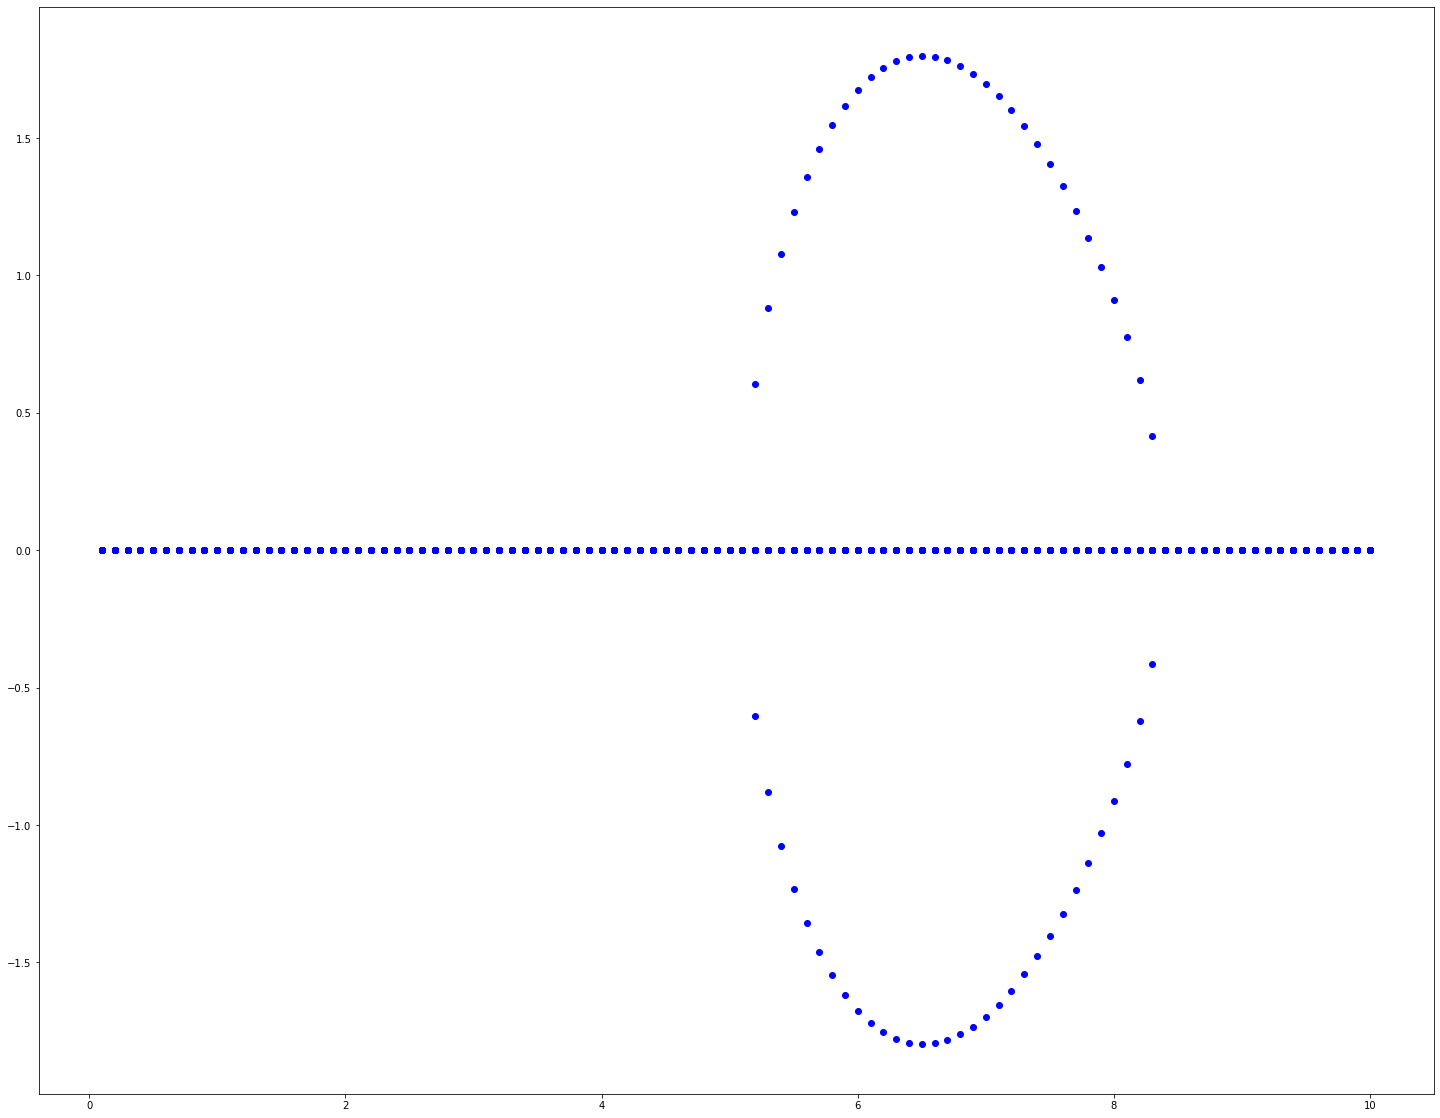

In [81]:
plt.plot(tti, eigs, "bo")

#### Lyapunov's direct (2nd) method

In [82]:
# load with pickle
#pickle_data = {"Vdot":Vdot, "Vdot_traj":Vdot_traj, "Vdot_traj_num":Vdot_traj_num, "hesse": hesse, "hesse0": hesse0}

load_hesse = 1

if load_hesse == 1:
    with open("hesse_matrix.pcl", "rb") as pfile:
        data = pickle.load(pfile)
        locals().update(data)

else:
    Vdot_traj = Vdot.subz(flat_quantities, flat_quant_subs)
    Vdot_traj_num = Vdot_traj.subs(sys_params)
    hesse = sp.hessian(Vdot_traj_num, eerror)
    hesse0 = hesse.subz0(eerror)

In [83]:
Vdot0 = Vdot_traj_num.subz0(eerror)

In [84]:
Vdot0i = []

for ti in tti:
    Vdot0i.append(Vdot0.subs(t, ti))

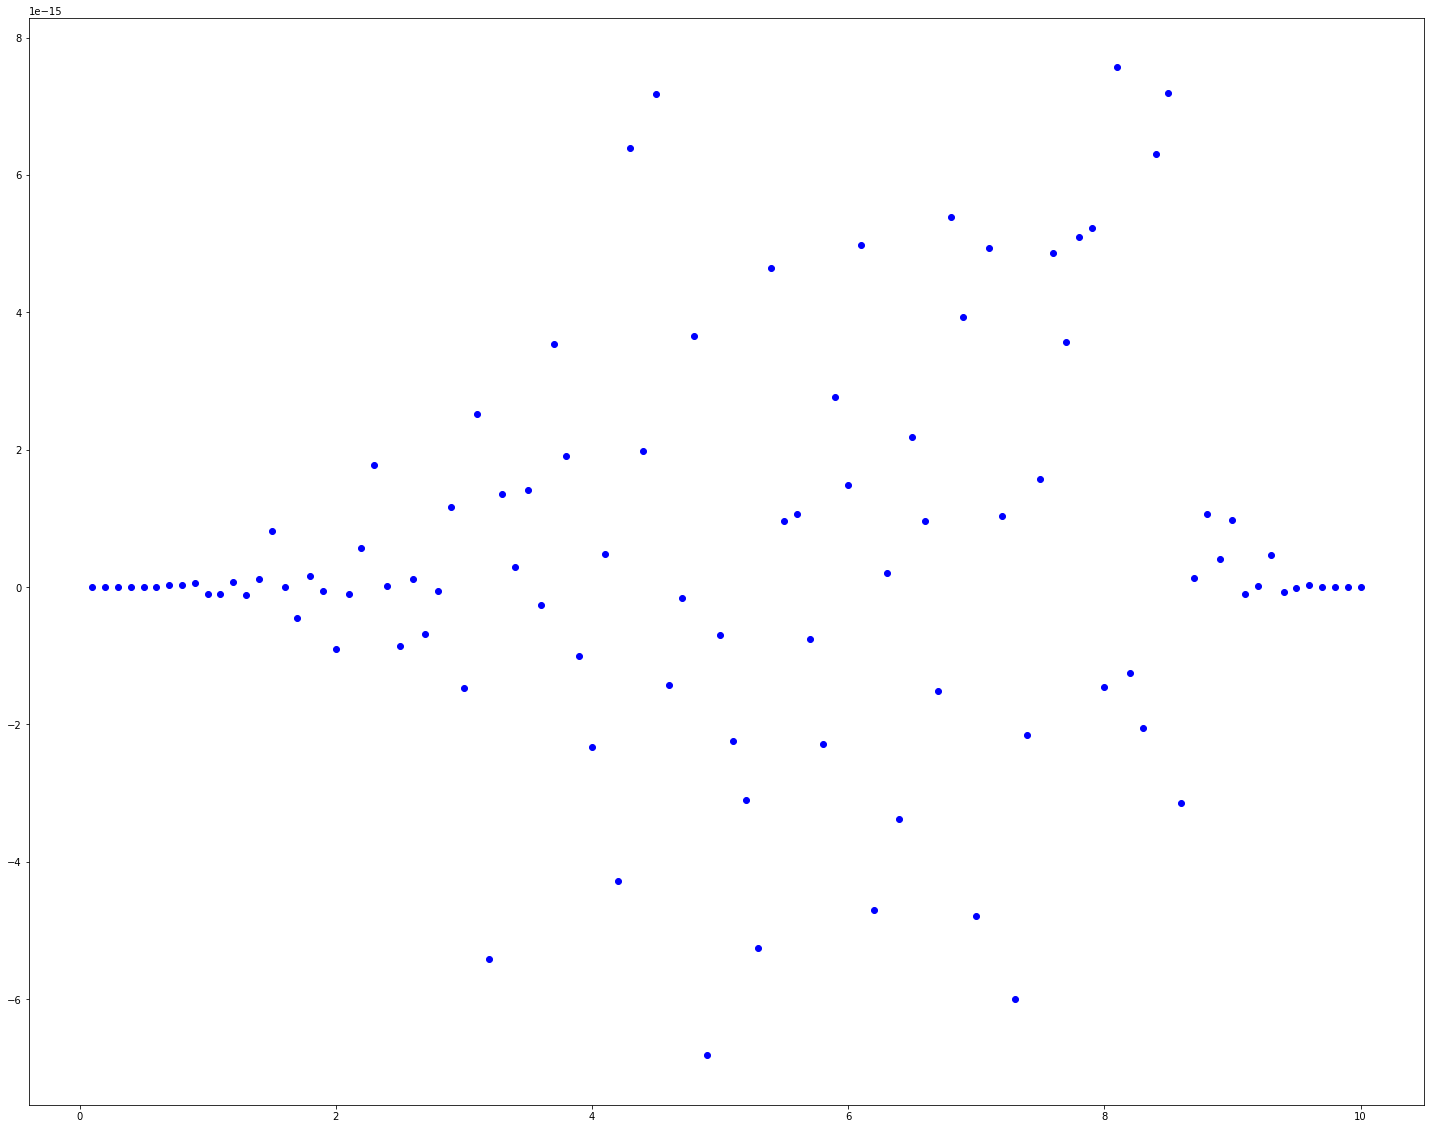

In [85]:
plt.plot(tti, Vdot0i, "bo")

In [86]:
%%time
hesse0ti = hesse0.subs(t, 10).evalf()

CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 193 ms


In [87]:
hesse0ti_eigs = npy.linalg.eig(st.to_np(hesse0ti))[0]

In [88]:
npy.real(hesse0ti_eigs)

array([ 7.50162648e+01, -7.90073165e+01,  1.39859309e+01, -1.59068925e+01, -2.15921161e+00, -4.06778876e+00,  7.30182435e-02,  6.59954628e-02, -4.00000000e+00,  5.55045920e-16])

#### V, Vdot development for simulated trajectory

In [89]:
error_traj = npy.array([err_trajp1, err_trajp2, err_trajp3, err_trajq1, err_trajq2, err_trajpdot1, err_trajpdot2, err_trajpdot3, err_trajqdot1, err_trajqdot2])

In [90]:
V_traj = []
for i in range(0, len(error_traj)):
    V_traj = 0.5 * npy.square(error_traj[i, :])

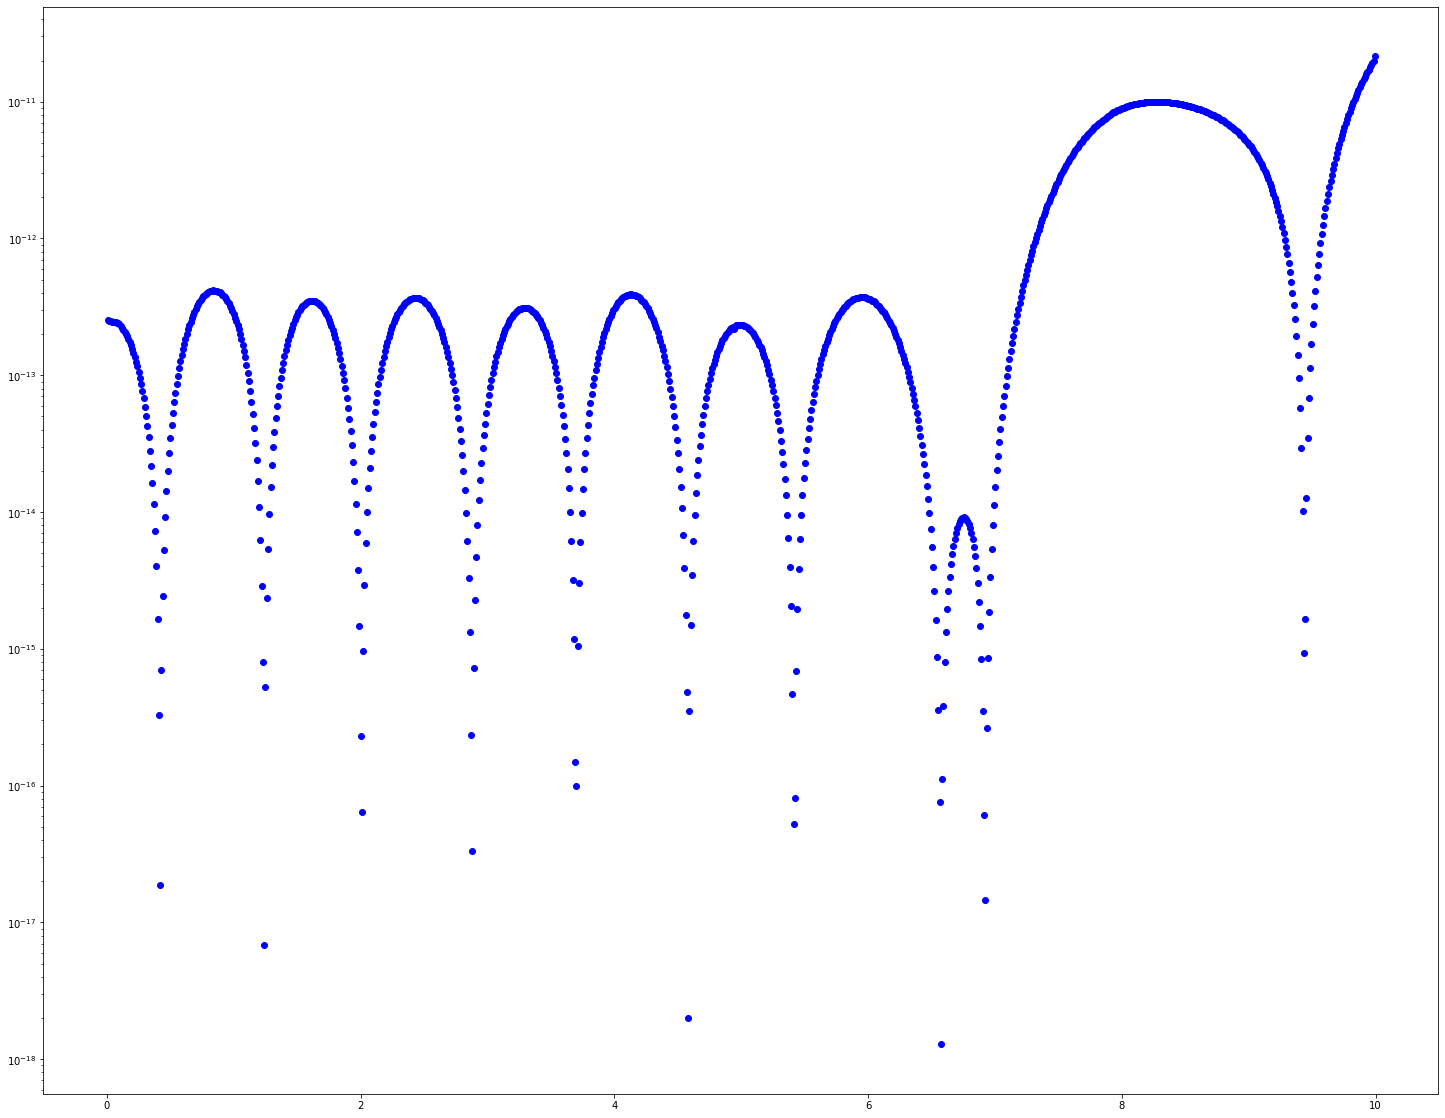

In [91]:
plt.semilogy(tt[:1000], V_traj, "bo")

In [ ]:
joint_pos_expr = st.col_stack(G1, G3, G4, G6).subs(sys_params) ##:
joint_pos_func = st.expr_to_func(mod.tt, joint_pos_expr, keep_shape=True)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = pl.figure() 
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.3,2.3), ylim=(-2.3,2.3))
ax.set_aspect('equal')

line, = ax.plot([],[],'o-', lw=2)
time_template = 'time=%.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
dt = tt[1] - tt[0]


def init():
    line.set_data([],[])
    time_text.set_text('')
    return line, time_text

l1 =1.0

def animate(i):
    xx, yy = joint_pos_func(*res[i, :res.shape[1]//2])
    
    line.set_data(xx,yy)
    time_text.set_text(time_template%(i*dt))
    
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(res.shape[0]), interval=tt[-1]*3, blit=True, init_func=init)


# this animation is nice but results in a big notebook file which is unwanted for publication in the repo
HTML(ani.to_jshtml())



